# Data Preparation 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

opp = pd.read_excel("C:/Users/zxy/Desktop/Capstone/Data/Copy of Ricoh_Opps_08022024.xlsx")

In [2]:
opp.columns = opp.columns.str.lower()
opp.columns

Index(['key', 'lead_number', 'opportunity_number', 'quote_number',
       'order_number', 'l2_rise_number', 'funnel_stage', 'lead_status_name',
       'lead_sub_source', 'lead_primary_product', 'customer_segment',
       'crm_industry', 'a4_bw_flag', 'a4_c_flag', 'a3_bw_flag', 'a3_c_flag',
       'docuware_flag', 'ransomcare_flag', 'it_health_check_flag', 'ms_flag',
       'pp_bw_cs_flag', 'pp_c_cs_flag', 'wf_bw_flag', 'wf_c_flag',
       'bw_lp_flag', 'color_lp_flag', 'mfp_flag', 'mindshift_flag',
       'lead_date', 'opp_date', 'opp_rev', 'quote_date', 'quote_rev',
       'order_date', 'order_rev', 'close_date', 'sales_stage_status', 'closed',
       'has_lead', 'start_date', 'open_days', 'close_days', 'win', 'rev',
       'eloqua', 'eloqua oc', 'lead', 'opp', 'order', 'quote', 'sales', 'web',
       'webinar', 'cs', 'hw', 'its', 'ms off', 'ms on', 'ps', 'refi', 'rent',
       'supp', 'ts', 'svc_calls', 'cv', 'mif', 'renewal', 'sat', 'nps',
       'department', 'job_type', 'employees

In [3]:
import seaborn as sns
import squarify
import statsmodels.api as sm
from tabulate import tabulate
import warnings
from functools import reduce
from sklearn.impute import KNNImputer
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler

import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from sklearn.decomposition import PCA

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

%matplotlib inline 

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None) 
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 200)

In [4]:
def na_check(df, na_only = True): 
    na = df.isna().mean()*100
    if na_only == False:
        print(na)
    else:
        print(na[na>0])

def plot_2d(x, dim_method, cluster_method, label):
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(x[:, 0], x[:, 1], c=label, cmap='viridis', s=50, alpha=0.6)
    plt.colorbar(scatter)
    plt.title(f'{cluster_method} Clusters on {dim_method} Reduced Data')
    plt.xlabel(f'{dim_method} Axis 1')
    plt.ylabel(f'{dim_method} Axis 2')
    plt.show()

def plot_2d_cat(x, dim_method, cluster_method, label):
    label_codes = pd.Categorical(label).codes
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(x[:, 0], x[:, 1], c=label_codes, cmap='viridis', s=50, alpha=0.6)
    plt.colorbar(scatter, ticks=range(len(pd.unique(label))), label='Cluster Labels')
    plt.title(f'{cluster_method} Clusters on {dim_method} Reduced Data')
    plt.xlabel(f'{dim_method} Axis 1')
    plt.ylabel(f'{dim_method} Axis 2')
    plt.show()

def plot_3d(x, dim_method, cluster_method, label):
    
    trace = go.Scatter3d(
        x=x[:, 0],
        y=x[:, 1],
        z=x[:, 2],
        mode='markers',
        marker=dict(
            size=1,
            color=label,  # Assign a unique color to each point for better visualization
            colorscale='Viridis',  # Color scale to use
            opacity=0.8
        )
    )
    
    # Creating the layout
    layout = go.Layout(
        margin=dict(l=0, r=0, b=0, t=0),
        title=f'3D {dim_method} - {cluster_method} Visualization',
        scene=dict(
            xaxis=dict(title=f'{dim_method} Axis 1'),
            yaxis=dict(title=f'{dim_method} Axis 2'),
            zaxis=dict(title=f'{dim_method} Axis 3')
        )
    )
    fig = go.Figure(data=[trace], layout=layout)
    fig.show()

In [5]:
# categorize
print(opp.columns.get_loc("eloqua"))
print(opp.columns.get_loc("webinar"))
print(opp.columns.get_loc("sat"))
print(opp.columns.get_loc("cs"))
print(opp.columns.get_loc("renewal"))
eng_cols = opp.columns[44:53].tolist()
sat_cols = opp.columns[67:69].tolist()
key_cols = ['key', 'opportunity_number', 'lead_number', 'quote_number', 'order_number', 'l2_rise_number']
cat_cols = opp.select_dtypes(include=['object']).columns
inv_cols = opp.columns[53:67].tolist()
flag_cols = [col for col in opp.columns if "flag" in col]
rev_cols = [col for col in opp.columns if 'rev' in col]
dt_cols = [col for col in opp.columns if 'date' in col]

44
52
67
53
66


In [6]:
# Before split to lead & opp cats

# 1. filter based on problem of interest

# remove missing l2 - remove for general purpose
opp = opp[opp.l2_rise_number.notnull()]

# closed deals for now
opp = opp[opp.closed == 1].drop(['closed'], axis = 1)

# 2. type conversion

opp['quote_number'] = opp['quote_number'].apply(lambda x: str(int(x)) if pd.notna(x) else np.nan)
opp['order_number'] = opp['order_number'].apply(lambda x: str(int(x)) if pd.notna(x) else np.nan)

for col_name in dt_cols: 
    opp[col_name] = pd.to_datetime(opp[col_name])


# 3. clean up string col format

# Remove trailing white spaces for char cols (department has trailing white spaces, so just clean all) 
num_cols = opp.select_dtypes(include=['number']).columns
cat_cols = opp.select_dtypes(include=['object']).columns
opp[cat_cols] = opp[cat_cols].apply(lambda x: x.str.rstrip())

# 4. fix NAs not effected by lead/opp type
# treat missing quote and order revenues as 0, probably is actual 0.
opp['quote_rev'].fillna(0, inplace = True)
opp['order_rev'].fillna(0, inplace = True)

# 5.
# add a opportunity ind
opp['has_opp'] = opp['opportunity_number'].notna().astype(int)

In [7]:
# fix numeric by parts
# impute engagement to 0, this is stats about past stuff, should be here, if not just 0 
for col in eng_cols:
    opp[col] = opp[col].fillna(0)

# impute inv to 0; checked if order_date na, no inv anyways
for col in inv_cols:
    opp[col] = opp[col].fillna(0)

# impute flag with mean for now: a probabilty assigned to a more general population, try knn 
# only missing when it's a lead, so just use a mean, 
for col in flag_cols:
    opp[col] = opp[col].fillna(opp[col].mean())

for col in sat_cols:
    opp[col] = opp[col].fillna(opp[col].mean())

for col in ['employees_dnb', 'sales_dnb']:
    opp[col] = opp[col].fillna(0)
#impute_cols = ["employees_dnb","sales_dnb"]  # need more l2 related cols to do this, but skip for now
#imputer = KNNImputer(n_neighbors = 5)
#opp[impute_cols] = imputer.fit_transform(opp[impute_cols])

In [8]:
oppo = opp[opp.has_opp == 1]
lead_cols = [col for col in oppo.columns if "lead" in col]
lead_cols.remove('lead')
oppo.drop(columns = lead_cols, inplace = True)

In [9]:
print(oppo.isna().sum())

key                          0
opportunity_number           0
quote_number            181584
order_number            327428
l2_rise_number               0
funnel_stage                 0
customer_segment             0
crm_industry                 0
a4_bw_flag                   0
a4_c_flag                    0
a3_bw_flag                   0
a3_c_flag                    0
docuware_flag                0
ransomcare_flag              0
it_health_check_flag         0
ms_flag                      0
pp_bw_cs_flag                0
pp_c_cs_flag                 0
wf_bw_flag                   0
wf_c_flag                    0
bw_lp_flag                   0
color_lp_flag                0
mfp_flag                     0
mindshift_flag               0
opp_date                     0
opp_rev                    851
quote_date              181584
quote_rev                    0
order_date              477949
order_rev                    0
close_date                  12
sales_stage_status           0
start_da

# Top 30 order revenue for closed deals

In [10]:
ranked_by_order_rev = opp.sort_values(by='order_rev', ascending=False)

top_30_order_rev = ranked_by_order_rev.head(30)
print("Top 30 Order_Rev:")
print(top_30_order_rev)

Top 30 Order_Rev:
               key   lead_number opportunity_number quote_number order_number  \
263   O-1002196655           NaN       O-1002196655     32593918    102968429   
279   O-1002799978           NaN       O-1002799978     34527867    106408334   
291   L-1000582771  L-1000582771       O-1001442727     29647448     80625966   
339   O-1001959650           NaN       O-1001959650     31678470    101942864   
691   O-1001874940           NaN       O-1001874940     31433488    101527755   
1249  O-1002361742           NaN       O-1002361742     33034982    104131482   
1445  O-1000681686           NaN       O-1000681686     28970530     78160871   
1469  O-1001463256           NaN       O-1001463256     29613583     80171808   
1483  O-1001426947           NaN       O-1001426947     31734073    105153603   
1502  O-1002510774           NaN       O-1002510774     33447098    105383819   
1563  O-1001863885           NaN       O-1001863885     31377756    102104839   
1603  O-10

In [11]:
print(top_30_order_rev.isna().sum())

key                      0
lead_number             29
opportunity_number       0
quote_number             0
order_number             0
l2_rise_number           0
funnel_stage             0
lead_status_name        29
lead_sub_source         29
lead_primary_product    29
customer_segment         0
crm_industry             0
a4_bw_flag               0
a4_c_flag                0
a3_bw_flag               0
a3_c_flag                0
docuware_flag            0
ransomcare_flag          0
it_health_check_flag     0
ms_flag                  0
pp_bw_cs_flag            0
pp_c_cs_flag             0
wf_bw_flag               0
wf_c_flag                0
bw_lp_flag               0
color_lp_flag            0
mfp_flag                 0
mindshift_flag           0
lead_date               29
opp_date                 0
opp_rev                  0
quote_date               0
quote_rev                0
order_date               0
order_rev                0
close_date               0
sales_stage_status       0
h

In [12]:
opp30 = top_30_order_rev.copy()

In [13]:
opp30.columns

Index(['key', 'lead_number', 'opportunity_number', 'quote_number',
       'order_number', 'l2_rise_number', 'funnel_stage', 'lead_status_name',
       'lead_sub_source', 'lead_primary_product', 'customer_segment',
       'crm_industry', 'a4_bw_flag', 'a4_c_flag', 'a3_bw_flag', 'a3_c_flag',
       'docuware_flag', 'ransomcare_flag', 'it_health_check_flag', 'ms_flag',
       'pp_bw_cs_flag', 'pp_c_cs_flag', 'wf_bw_flag', 'wf_c_flag',
       'bw_lp_flag', 'color_lp_flag', 'mfp_flag', 'mindshift_flag',
       'lead_date', 'opp_date', 'opp_rev', 'quote_date', 'quote_rev',
       'order_date', 'order_rev', 'close_date', 'sales_stage_status',
       'has_lead', 'start_date', 'open_days', 'close_days', 'win', 'rev',
       'eloqua', 'eloqua oc', 'lead', 'opp', 'order', 'quote', 'sales', 'web',
       'webinar', 'cs', 'hw', 'its', 'ms off', 'ms on', 'ps', 'refi', 'rent',
       'supp', 'ts', 'svc_calls', 'cv', 'mif', 'renewal', 'sat', 'nps',
       'department', 'job_type', 'employees_dnb', 'sa

# Top 30 Order revenue PCA

## Top 10 features highlighted 

Explained Variance for 3 components: 42.03%
Top 10 features contributing to PC1: ['cv', 'svc_calls', 'ts', 'ms on', 'a3_c_flag', 'a3_bw_flag', 'ms off', 'pp_bw_cs_flag', 'renewal', 'pp_c_cs_flag']
Top 10 features contributing to PC2: ['refi', 'webinar', 'a3_c_flag', 'a4_bw_flag', 'pp_bw_cs_flag', 'ts', 'ms off', 'pp_c_cs_flag', 'mif', 'a4_c_flag']
Top 10 features contributing to PC3: ['hw', 'supp', 'ps', 'ms_flag', 'webinar', 'refi', 'renewal', 'rent', 'cs', 'web']


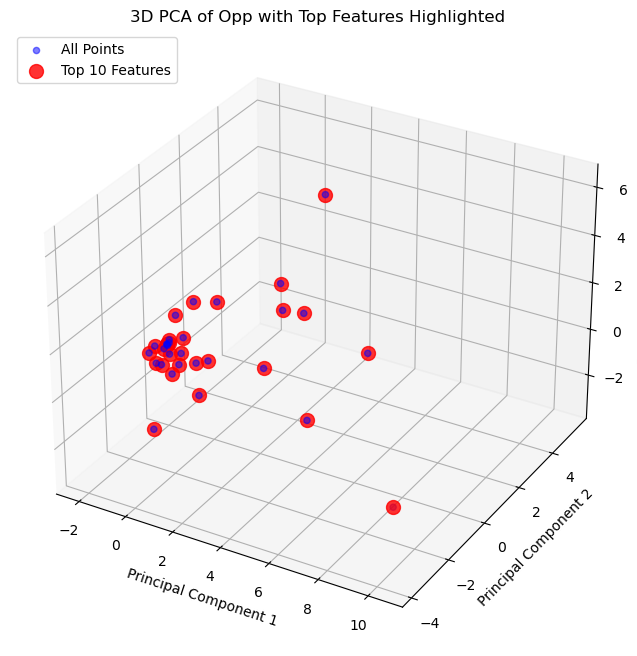

In [15]:
from sklearn.preprocessing import StandardScaler

oppo30 = opp30[opp30.has_opp == 1]  # Filter rows where has_opp is 1
lead_cols = [col for col in oppo30.columns if "lead" in col]  # Identify lead columns
lead_cols.remove('lead')  # Remove 'lead' column from lead_cols list
oppo30.drop(columns=lead_cols, inplace=True)  # Drop all lead columns except 'lead'

# Define lists for product flags and metrics
product_flags = ['a4_bw_flag', 'a4_c_flag', 'a3_bw_flag', 'a3_c_flag', 
                 'docuware_flag', 'ransomcare_flag', 'it_health_check_flag', 
                 'ms_flag', 'pp_bw_cs_flag', 'pp_c_cs_flag']
metrics = ['win', 'svc_calls', 'cv', 'mif', 'renewal', 'sat', 'nps', 
           'employees_dnb', 'sales_dnb', 'has_opp', 'web', 'webinar', 
           'cs', 'hw', 'its', 'ms off', 'ms on', 'ps', 'refi', 'rent', 
           'supp', 'ts']

# Define categorical columns for one-hot encoding
categorical_col = ['customer_segment', 'crm_industry', 'sales_stage_status', 'funnel_stage']

# One-hot encode categorical variables
oppo30 = pd.get_dummies(oppo30, columns=categorical_col)
data = oppo30[product_flags + metrics]  # Select relevant columns for analysis

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Apply PCA
pca = PCA(n_components=3)
pca_data = pca.fit_transform(data_scaled)

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained Variance for 3 components: {explained_variance * 100:.2f}%")

# Create a DataFrame for the PCA components
components_df = pd.DataFrame(pca.components_, columns=data.columns)

# top 10 features 
top_10_features = components_df.iloc[0].abs().nlargest(10).index.tolist()

# Identify the top 10 features contributing to PC1,PC2,PC3
top_10_features_pc1 = components_df.iloc[0].abs().nlargest(10).index.tolist()
top_10_features_pc2 = components_df.iloc[1].abs().nlargest(10).index.tolist()
top_10_features_pc3 = components_df.iloc[2].abs().nlargest(10).index.tolist()

print("Top 10 features contributing to PC1:", top_10_features_pc1)
print("Top 10 features contributing to PC2:", top_10_features_pc2)
print("Top 10 features contributing to PC3:", top_10_features_pc3)

# Highlighting the top features
highlight_mask = data.columns.isin(top_10_features)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter all points
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2', 'PC3'])  # Convert PCA data to DataFrame
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], color='blue', alpha=0.5)

# Highlight points related to top features
for i in range(len(pca_df)):
    if any(highlight_mask):
        ax.scatter(pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i], pca_df['PC3'].iloc[i],
                   color='red', s=100, alpha=0.8)  # Highlighted points for top features

# Customize the plot
ax.set_title('3D PCA of Opp with Top Features Highlighted')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add legend
plt.legend(['All Points', 'Top 10 Features'], loc='upper left')

plt.show()


## add win status color bar beside and create 'win' status check graph 

Explained Variance for 3 components: 42.03%
Top 10 features contributing to PC1: ['cv', 'svc_calls', 'ts', 'ms on', 'a3_c_flag', 'a3_bw_flag', 'ms off', 'pp_bw_cs_flag', 'renewal', 'pp_c_cs_flag']
Top 10 features contributing to PC2: ['refi', 'webinar', 'a3_c_flag', 'a4_bw_flag', 'pp_bw_cs_flag', 'ts', 'ms off', 'pp_c_cs_flag', 'mif', 'a4_c_flag']
Top 10 features contributing to PC3: ['hw', 'supp', 'ps', 'ms_flag', 'webinar', 'refi', 'renewal', 'rent', 'cs', 'web']


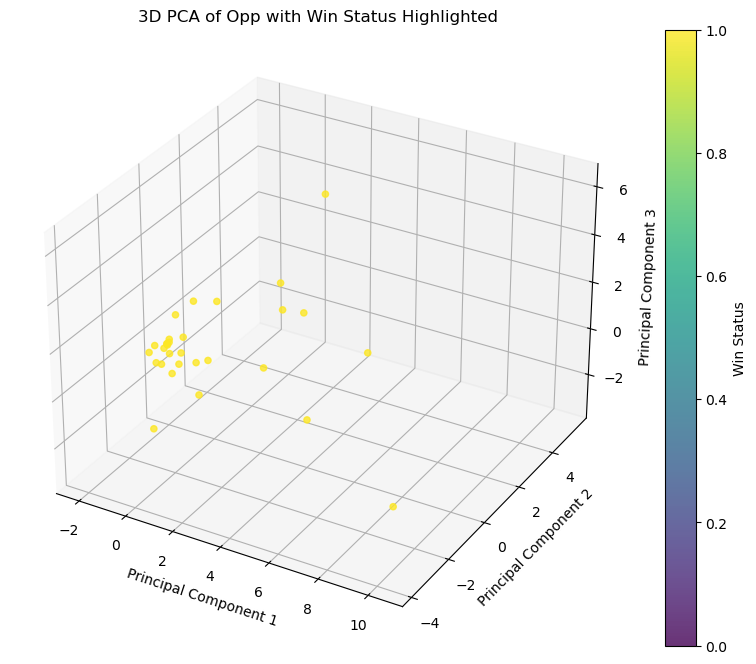

In [16]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import numpy as np

# Apply data preprocessing
oppo30 = opp30[oppo30.has_opp == 1]  # Filter rows where has_opp is 1
lead_cols = [col for col in oppo30.columns if "lead" in col]
lead_cols.remove('lead')
oppo30.drop(columns=lead_cols, inplace=True)

product_flags = ['a4_bw_flag', 'a4_c_flag', 'a3_bw_flag', 'a3_c_flag', 
                 'docuware_flag', 'ransomcare_flag', 'it_health_check_flag', 
                 'ms_flag', 'pp_bw_cs_flag', 'pp_c_cs_flag']
metrics = ['win', 'svc_calls', 'cv', 'mif', 'renewal', 'sat', 'nps', 
           'employees_dnb', 'sales_dnb', 'has_opp', 'web', 'webinar', 
           'cs', 'hw', 'its', 'ms off', 'ms on', 'ps', 'refi', 'rent', 
           'supp', 'ts']
categorical_col = ['customer_segment', 'crm_industry', 'sales_stage_status', 'funnel_stage']

# One-hot encode categorical variables
oppo30 = pd.get_dummies(oppo30, columns=categorical_col)
data = oppo30[product_flags + metrics]

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Apply PCA
pca = PCA(n_components=3)
pca_data = pca.fit_transform(data_scaled)

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained Variance for 3 components: {explained_variance * 100:.2f}%")

# Create DataFrame for PCA components
components_df = pd.DataFrame(pca.components_, columns=data.columns)
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2', 'PC3'])
pca_df['win'] = data['win'].values  # Add win status as a column

# Identify top 10 features for each component
top_10_features_pc1 = components_df.iloc[0].abs().nlargest(10).index.tolist()
top_10_features_pc2 = components_df.iloc[1].abs().nlargest(10).index.tolist()
top_10_features_pc3 = components_df.iloc[2].abs().nlargest(10).index.tolist()

print("Top 10 features contributing to PC1:", top_10_features_pc1)
print("Top 10 features contributing to PC2:", top_10_features_pc2)
print("Top 10 features contributing to PC3:", top_10_features_pc3)

# Create a 3D scatter plot with color mapping based on 'win' status
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with win status as color
scatter = ax.scatter(pca_df['PC1'], pca_df['PC2'], pca_df['PC3'],
                     c=pca_df['win'], cmap='viridis',vmin=0, vmax=1, alpha=0.8)

# Color bar for 'win' status
cbar = plt.colorbar(scatter, ax=ax, label='Win Status')
cbar.set_label('Win Status')

# Customize plot
ax.set_title('3D PCA of Opp with Win Status Highlighted')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Show plot
plt.show()


Explained Variance for 3 components: 42.03%
Top 10 features contributing to PC1: ['cv', 'svc_calls', 'ts', 'ms on', 'a3_c_flag', 'a3_bw_flag', 'ms off', 'pp_bw_cs_flag', 'renewal', 'pp_c_cs_flag']
Top 10 features contributing to PC2: ['refi', 'webinar', 'a3_c_flag', 'a4_bw_flag', 'pp_bw_cs_flag', 'ts', 'ms off', 'pp_c_cs_flag', 'mif', 'a4_c_flag']
Top 10 features contributing to PC3: ['hw', 'supp', 'ps', 'ms_flag', 'webinar', 'refi', 'renewal', 'rent', 'cs', 'web']


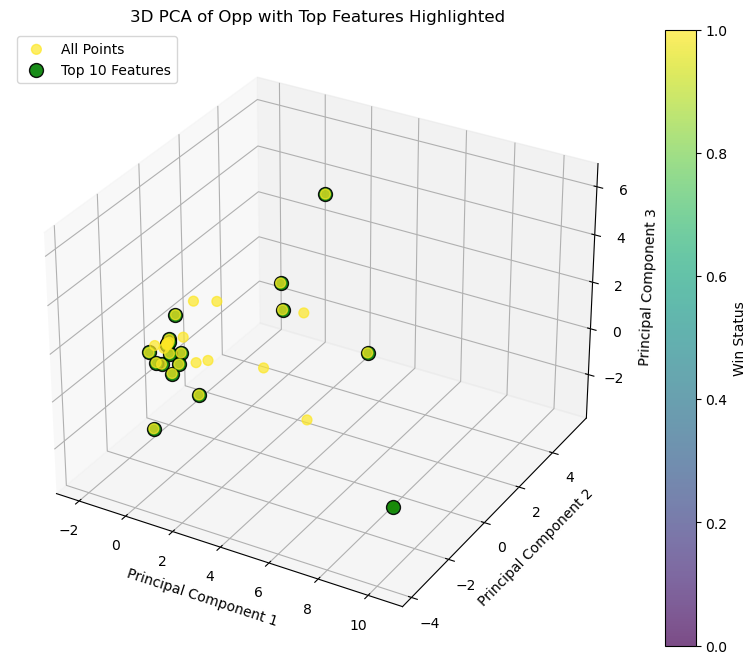

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained Variance for 3 components: {explained_variance * 100:.2f}%")

# Create DataFrame for PCA components
components_df = pd.DataFrame(pca.components_, columns=data.columns)
pca_df = pd.DataFrame(pca_data, columns=['PC1', 'PC2', 'PC3'])
pca_df['win'] = data['win'].values  # Add win status as a column

# Identify top 10 features for each component
top_10_features_pc1 = components_df.iloc[0].abs().nlargest(10).index.tolist()
top_10_features_pc2 = components_df.iloc[1].abs().nlargest(10).index.tolist()
top_10_features_pc3 = components_df.iloc[2].abs().nlargest(10).index.tolist()

print("Top 10 features contributing to PC1:", top_10_features_pc1)
print("Top 10 features contributing to PC2:", top_10_features_pc2)
print("Top 10 features contributing to PC3:", top_10_features_pc3)

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colors based on 'win' values, ensuring the color range is 0 to 1
scatter = ax.scatter(
    pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], 
    c=pca_df['win'], cmap='viridis', vmin=0, vmax=1, alpha=0.7, s=50  # Set vmin and vmax
)

# Highlighting the top features with a distinct color (e.g., green) and larger size
highlight_mask = data.columns.isin(top_10_features_pc1 + top_10_features_pc2 + top_10_features_pc3)
highlight_color = 'green'

for i in range(len(pca_df)):
    if highlight_mask[i]:
        ax.scatter(
            pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i], pca_df['PC3'].iloc[i],
            color=highlight_color, edgecolor='k', s=100, alpha=0.9  # Larger size for top features
        )

# Customize the plot
cbar = plt.colorbar(scatter, label='Win Status')
ax.set_title('3D PCA of Opp with Top Features Highlighted')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Adjust legend to indicate top 10 feature highlights
plt.legend(['All Points', 'Top 10 Features'], loc='upper left')

plt.show()


## same graph as above for dinstinction and later interpretation 

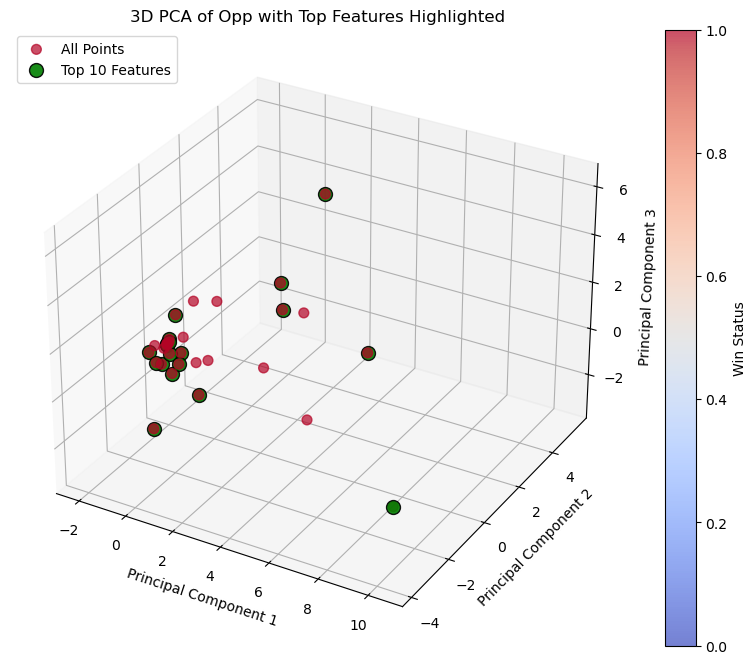

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colors based on 'win' values, ensuring the color range is 0 to 1
scatter = ax.scatter(
    pca_df['PC1'], pca_df['PC2'], pca_df['PC3'], 
    c=pca_df['win'], cmap='coolwarm', vmin=0, vmax=1, alpha=0.7, s=50  # Set vmin and vmax
)

# Highlighting the top features with a distinct color (e.g., green) and larger size
highlight_mask = data.columns.isin(top_10_features_pc1 + top_10_features_pc2 + top_10_features_pc3)
highlight_color = 'green'

for i in range(len(pca_df)):
    if highlight_mask[i]:
        ax.scatter(
            pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i], pca_df['PC3'].iloc[i],
            color=highlight_color, edgecolor='k', s=100, alpha=0.9  # Larger size for top features
        )

# Customize the plot
cbar = plt.colorbar(scatter, label='Win Status')
ax.set_title('3D PCA of Opp with Top Features Highlighted')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Adjust legend to indicate top 10 feature highlights
plt.legend(['All Points', 'Top 10 Features'], loc='upper left')


plt.show()


## marketing engagment 

In [19]:
oppo30 = opp30[opp30.has_opp == 1]  
lead_cols = [col for col in oppo30.columns if "lead" in col]  
lead_cols.remove('lead')  
oppo30.drop(columns=lead_cols, inplace=True)  

from sklearn.preprocessing import StandardScaler, OneHotEncoder

categorical_cols = ['customer_segment', 'crm_industry']
oppo30 = pd.get_dummies(oppo30, columns=categorical_cols)

numeric_cols = ['svc_calls', 'cv', 'mif', 'renewal','sat', 'nps', 'web','webinar']
data_numeric = oppo30[numeric_cols]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

pca = PCA(n_components=3)
pca_data = pca.fit_transform(data_scaled)

explained_variance = pca.explained_variance_ratio_.sum()
print(f"Explained Variance for 3 components: {explained_variance * 100:.2f}%")

components_df = pd.DataFrame(pca.components_, columns=numeric_cols)
print("Top contributing features for each component:\n", components_df)

Explained Variance for 3 components: 68.52%
Top contributing features for each component:
    svc_calls        cv       mif   renewal       sat       nps       web  \
0   0.532788  0.533730  0.302269  0.510029  0.160029  0.203540  0.071560   
1  -0.288549 -0.291346  0.217273  0.036610  0.580448  0.661870  0.052762   
2  -0.266020 -0.269356  0.583865  0.257866 -0.385960 -0.098664  0.425290   

    webinar  
0 -0.087266  
1  0.074393  
2 -0.331234  


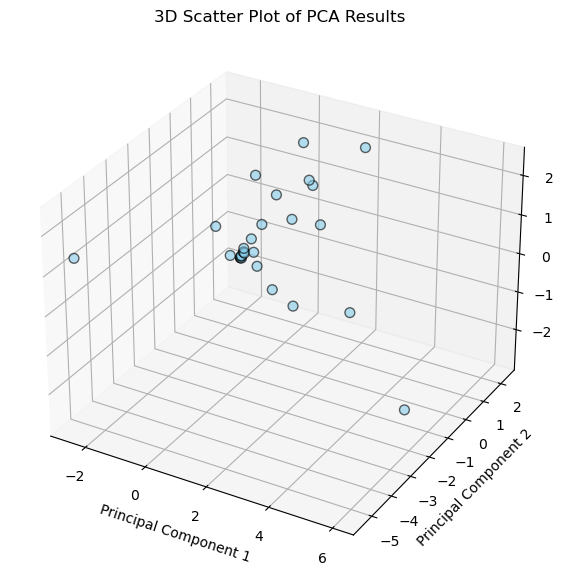

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(pca_data[:, 0], pca_data[:, 1], pca_data[:, 2], c='skyblue', s=50, alpha=0.6, edgecolor='k')

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.title("3D Scatter Plot of PCA Results")
plt.show()